In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
# Standard library imports
from typing import Union, Dict, Tuple
from pathlib import Path
import pandas as pd
import xarray as xr
from neuralhydrology.nh_run_data_dir import cached_eval_run
from neuralhydrology.evaluation.metrics import nse
import matplotlib.pyplot as plt


def combine_datasets(results: Dict[int, Dict[str, Dict[str, Union[str, pd.DataFrame]]]]) -> pd.DataFrame:
    """
    Combine datasets from multiple folds.

    Parameters
    ----------
    results : Dict[int, Dict[str, Dict[str, Union[str, pd.DataFrame]]]]
        Dictionary containing results for different folds.

    Returns
    -------
    pd.DataFrame
        Combined DataFrame.
    """
    basins = []
    data_values = []
    folds = results.keys()
    for fold in folds:
        for k,v in results[fold].items():
            basins.append(k)
            data_values.append(v['1D']['xr'])

    basins = [basin for fold in results.values() for basin in fold]
    data_values = [entry['1D']['xr'] for fold in results.values() for entry in fold.values()]
    combined_dataset = xr.concat(data_values, dim='basin').assign_coords(basin=basins)
    return combined_dataset.to_dataframe()

def create_pivot_tables(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Create pivot tables for simulated and observed streamflow.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the streamflow data.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame]
        Tuple containing pivot tables for simulated and observed streamflow.
    """
    pivot_table_simulated = df.pivot_table(values='streamflow_mmd_sim', index='date', columns='basin')
    pivot_table_observed = df.pivot_table(values='streamflow_mmd_obs', index='date', columns='basin')
    return pivot_table_simulated, pivot_table_observed


def calculate_metric(df_sim, df_obs , metric, name='metric'):
    metric_dict = {catchment: {name: metric(df_sim.loc[df_obs.index, catchment],df_obs[catchment])} for catchment in df_obs.columns}
    return pd.DataFrame.from_dict(metric_dict).T


In [200]:
period = "test"

df_metrics_list =[]
# Set parameters

for predictors in ['Pra', 'Prs', 'PrsEts', 'PrsEas']:

    folds = [0, 1]
    base_path = Path('/Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs')

    result = {}
    for fold in folds:
        matching_dirs = list(base_path.glob(f'spatial_twofold_{fold}_{predictors}_????_??????'))
        
        if len(matching_dirs) != 1:
            raise ValueError(f"Expected one matching directory for fold {fold}, but found {len(matching_dirs)}: {matching_dirs}")
        
        result[fold] = cached_eval_run(
            run_dir=matching_dirs[0],
            period=period,
            data_dir='/Users/sho108/Desktop/z/Data/CAMELS_AUS',
        )


    # Extract basins and corresponding data values from the result dictionary
    df = combine_datasets(result)

    # Create pivot tables for simulated and observed streamflow
    df_sim, df_obs = create_pivot_tables(df)

    df_metric = calculate_metric(df_sim, df_obs, nse, name=f'spatial_twofold_{predictors}')

    df_metrics_list.append(df_metric)

df_metrics = pd.concat(df_metrics_list, axis=1)
attr_df = pd.read_csv('/Users/sho108/Desktop/z/Data/CAMELS_AUS/CAMELS_AUS_Attributes&Indices_MasterTable.csv', index_col=0)


Loading cached data for test from /Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/spatial_twofold_0_Pra_3001_172823/postprocess/test_cached_data.pkl
Loading cached data for test from /Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/spatial_twofold_1_Pra_3001_172823/postprocess/test_cached_data.pkl
Loading cached data for test from /Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/spatial_twofold_0_Prs_3001_172823/postprocess/test_cached_data.pkl
Loading cached data for test from /Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/spatial_twofold_1_Prs_3001_172823/postprocess/test_cached_data.pkl
Loading cached data for test from /Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/spatial_twofold_0_PrsEts_3001_172823/postprocess/test_cached_data.pkl
Loading cached data for test from /Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/spatial_twofold_1_PrsEts_3001_172823/postprocess/test_cached_d

In [290]:
data = pd.concat([df_metrics, attr_df], axis=1).reset_index()
#data_melted = data.melt(id_vars=['index'], value_vars = ['spatial_twofold_Pra','spatial_twofold_Prs','spatial_twofold_PrsEts','spatial_twofold_PrsEas', 'drainage_division'])
#data_melted

data_melted = data.melt(value_vars=df_metrics.columns, id_vars=['drainage_division', 'river_region', 'state_outlet'])
data_melted

,drainage_division,river_region,state_outlet,variable,value
0,North East Coast,OLIVE-PASCOE RIVERS,QLD,spatial_twofold_Pra,-0.539057
1,North East Coast,STEWART RIVER,QLD,spatial_twofold_Pra,0.379294
2,North East Coast,NORMANBY RIVER,QLD,spatial_twofold_Pra,0.429733
3,North East Coast,NORMANBY RIVER,QLD,spatial_twofold_Pra,-0.149557
4,North East Coast,NORMANBY RIVER,QLD,spatial_twofold_Pra,0.650973
...,...,...,...,...,...
883,Tanami-Timor Sea Coast,SOUTH ALLIGATOR RIVER,NT,spatial_twofold_PrsEas,0.236131
884,Tanami-Timor Sea Coast,EAST ALLIGATOR RIVER,NT,spatial_twofold_PrsEas,-0.344852
885,Carpentaria Coast,ROPER RIVER,NT,spatial_twofold_PrsEas,0.440734
886,Carpentaria Coast,ROPER RIVER,NT,spatial_twofold_PrsEas,0.416499


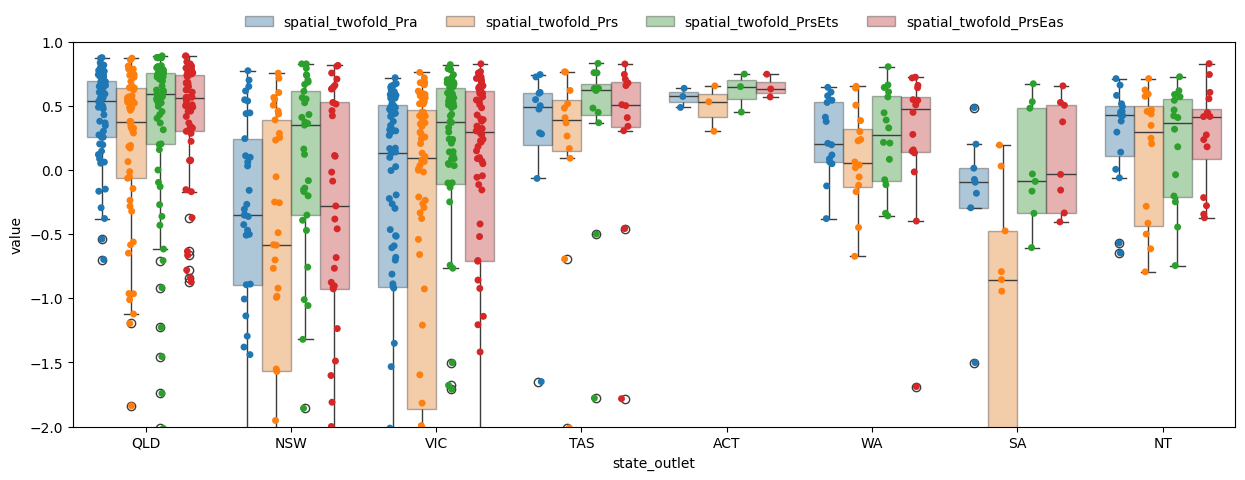

In [298]:
import seaborn as sns
plt.figure(figsize=(15,5))

x = 'state_outlet'
ax = sns.boxplot(data_melted , y='value', x=x, hue='variable', boxprops={'alpha': 0.4})
sns.stripplot(data=data_melted, y='value', x=x, hue='variable', dodge=True, ax=ax, legend=False)
plt.ylim(-2,1)


sns.move_legend(ax, "lower center",  bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,)


Text(0, 0.5, 'nse')

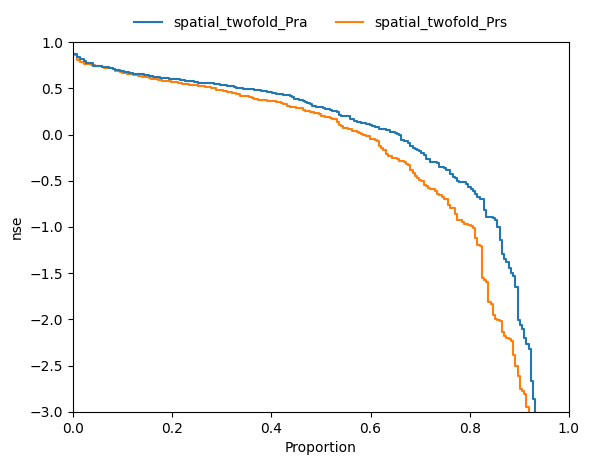

In [288]:
data_melted = data.melt(value_vars=['spatial_twofold_Pra', 'spatial_twofold_Prs'], id_vars=['drainage_division', 'river_region', 'state_outlet'])
import seaborn as sns


x = 'state_outlet'
ax = sns.ecdfplot(data_melted , y='value', hue='variable', complementary=True)
ax.set_ylim(-3,1)
sns.move_legend(ax, "lower center",    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,)
plt.ylabel('nse')

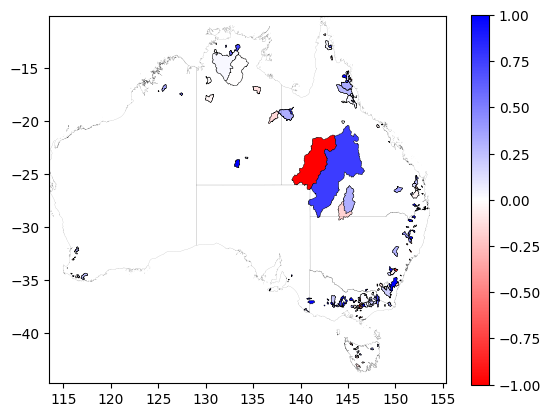

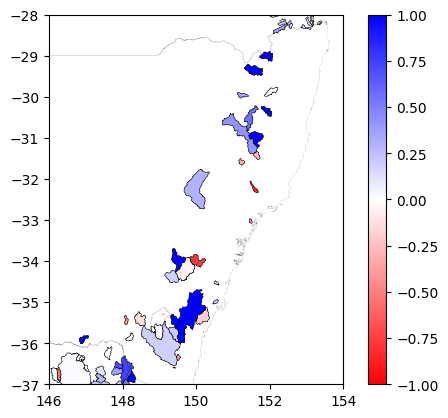

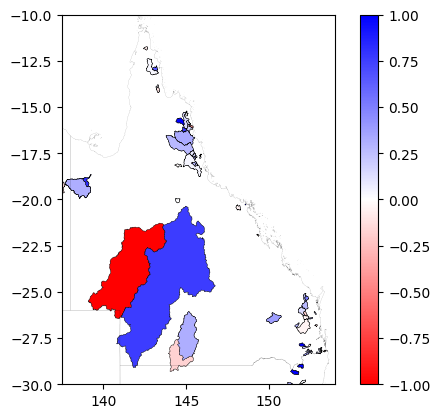

In [158]:
#{x:(113.54215277800002, 155.32840277800008), y:(-44.7681875, -10.158062499999929)}

#from neuralhydrology.utils.config import Config
from neuralhydrology.nh_run import eval_run
from pathlib import Path
from matplotlib import pyplot as plt
from neuralhydrology.evaluation.map import spatial_plot
import geopandas as gpd


shp_basepath = Path('/Users/sho108/Desktop/z/Data/CAMELS_AUS/02_location_boundary_area/shp')
aus_shpfile = shp_basepath / 'bonus data/Australia_boundaries.shp'
AUS = gpd.read_file(aus_shpfile)

basins_shpfile = shp_basepath / 'CAMELS_AUS_Boundaries_adopted.shp'
gdf = gpd.read_file(basins_shpfile)




df_m = df_metrics['spatial_twofold_Pra']-df_metrics['spatial_twofold_Prs']
df_m.name = 'nse'
gdf_merged = pd.merge(gdf, df_m, left_on= 'CatchID', right_index=True)


def plot_zone(gdf_merged, zone=None, **kwargs):
    # Plot the results on the map
    default_kwargs = dict(cmap='bwr_r', vmin=-1, vmax=1, legend=True, edgecolor='k', linewidth=0.3)
    kwargs = {**default_kwargs, **kwargs}
    
    ax = gdf_merged.plot(**kwargs)
    AUS.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.1, alpha=0.5)
    
    if zone:
        ax.set_xlim(zone['x'])
        ax.set_ylim(zone['y'])
    

# Define the entire zone
zone0 = {'x': (113.5, 155.3), 'y': (-44.7, -10.1)}
ul = {'x': (113.5, 134.4), 'y': (-27.4, -10.1)}
ur = {'x': (134.4, 155.3), 'y': (-27.4, -10.1)}
dl = {'x': (113.5, 134.4), 'y': (-44.7, -27.4)}
dr = {'x': (134.4, 155.3), 'y': (-44.7, -27.4)}
mdb = {'x': (140, 154), 'y': (-39, -25)}
nsw = {'x': (146, 154), 'y': (-37, -28)}
qld = {'x': (137.5, 154), 'y': (-30, -10)}
tas = {'x': (144.5, 148.5), 'y': (-43.75, -40.1)}
wa = {'x': (115, 118), 'y': (-35, -31)}
up = {'x': (122, 147), 'y': (-25, -10.1)}



plot_zone(gdf_merged, zone=zone0, column='nse')
#plot_zone(gdf_merged, zone=ul, column='nse')
#plot_zone(gdf_merged, zone=ur, column='nse')
#plot_zone(gdf_merged, zone=dl, column='nse')
#plot_zone(gdf_merged, zone=dr, column='nse')

#plot_zone(gdf_merged, zone=mdb, column='nse')
plot_zone(gdf_merged, zone=nsw, column='nse')
plot_zone(gdf_merged, zone=qld, column='nse')
#plot_zone(gdf_merged, zone=tas, column='nse')
#plot_zone(gdf_merged, zone=wa, column='nse')
#plot_zone(gdf_merged, zone=up, column='nse')



